In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()


In [111]:
# df = pd.read_csv("../results/fbs/ab-main-main-2022-08-26T11:51:31+02:00/combined-results.csv")
df = pd.read_csv("../results/fbs/ab-main-main-2022-08-26T12:54:59+02:00/combined-results.csv")
#df = pd.read_csv("../results/fbs/ab-main-perf-issue-request-id-2022-08-26T10:31:36+02:00/combined-results.csv")
#df = pd.read_csv("../results/fbs/ab-main-perf-issue-clean-path-2022-08-26T13:17:48+02:00/combined-results.csv")
df["version_scenario"] = df["version"] + "_" + df["scenario"]
df

,version,index,period,width,scenario,method,path,request_time_median,request_count,version_scenario
0,v1,0,1661511310000,7825,searchAndBookFlight,GET,/destinations,8.9,21,v1_searchAndBookFlight
1,v1,0,1661511310000,7825,searchFlights,GET,/destinations,8.9,59,v1_searchFlights
2,v1,0,1661511310000,7825,searchAndBookFlight,GET,/flights,7.9,19,v1_searchAndBookFlight
3,v1,0,1661511310000,7825,searchFlights,GET,/flights,7.0,102,v1_searchFlights
4,v1,0,1661511310000,7825,searchAndBookFlight,GET,/flights/$flightID/seats,2.0,15,v1_searchAndBookFlight
...,...,...,...,...,...,...,...,...,...,...
1519,v2,126,1661512570000,6917,searchAndBookFlight,POST,/bookings,1.0,190,v2_searchAndBookFlight
1520,v2,126,1661512570000,6917,searchFlights,GET,/flights,8.9,290,v2_searchFlights
1521,v2,126,1661512570000,6917,searchAndBookFlight,GET,/destinations,15.0,54,v2_searchAndBookFlight
1522,v2,126,1661512570000,6917,searchAndBookFlight,GET,/flights/$flightID/seats,2.0,114,v2_searchAndBookFlight


In [112]:
df_grouped = df.groupby(['index', 'version']).agg({'request_time_median': 'median', 'request_count': 'sum'}).reset_index()
df_grouped

,index,version,request_time_median,request_count
0,0,v1,7.45,221
1,0,v2,7.90,227
2,1,v1,7.00,337
3,1,v2,7.90,334
4,2,v1,7.45,326
...,...,...,...,...
249,124,v2,19.50,2661
250,125,v1,19.10,2681
251,125,v2,18.00,2665
252,126,v1,10.50,797


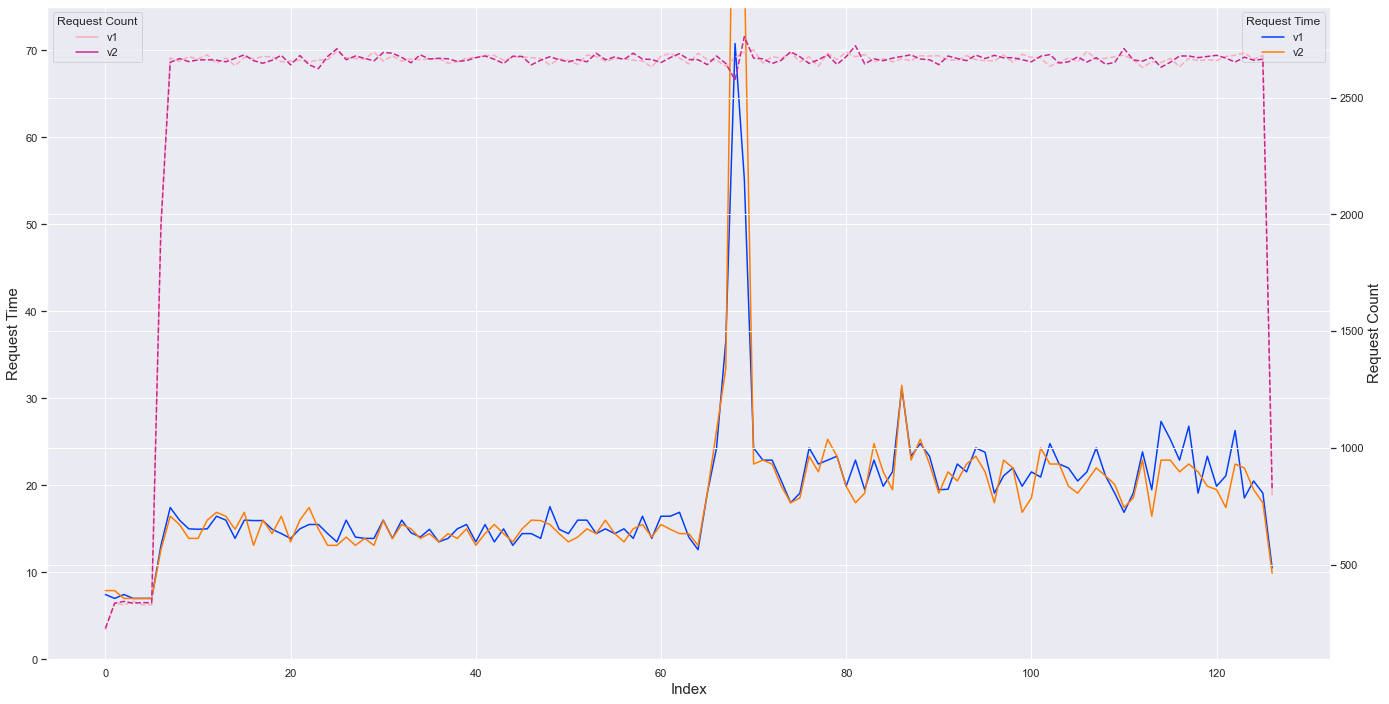

In [113]:

paletteTime = sns.color_palette("bright", 2)
paletteCount = sns.color_palette("RdPu", 2)

sns.set(rc={'figure.figsize':(23,12)})
g = sns.lineplot(data = df_grouped, x='index', y='request_time_median', hue='version', palette=paletteTime)
g.set_xlabel("Index", fontsize = 15)
g.set_ylabel("Request Time", fontsize = 15)
g.set_ylim([0, 75])
g.legend(title="Request Time")
ax2 = g.twinx()
ax2.set_ylabel("Request Count", fontsize = 15)
#ax2.set_ylim([0, 2000])
g2 = sns.lineplot(data = df_grouped, x='index', y='request_count', hue='version', ax=ax2, palette=paletteCount, linestyle="--")
g2.legend(title="Request Count", loc = 'upper left')

In [114]:
df_filtered = df_grouped[df_grouped['request_count'] > 1000]
df_filtered

,index,version,request_time_median,request_count
12,6,v1,13.10,1963
13,6,v2,12.60,1954
14,7,v1,17.45,2671
15,7,v2,16.45,2652
16,8,v1,16.00,2656
...,...,...,...,...
247,123,v2,22.00,2674
248,124,v1,20.50,2666
249,124,v2,19.50,2661
250,125,v1,19.10,2681


In [115]:
measurementIndexesSize = df_filtered['index'].max()- df_filtered['index'].min()
measurementIndexesSize

119

In [116]:
def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
  numberOfSamples = 10000
  allRuntimes1 = perfRuntimes1['request_time_median'].to_numpy()
  allRuntimes2 = perfRuntimes2['request_time_median'].to_numpy()
  currentMeasurementIndexes = rng.choice(measurementIndexesSize, size=(measurementIndexesSize, numberOfSamples))

  # Bulk selection
  tmp1 = allRuntimes1[currentMeasurementIndexes]
  tmp1 = np.stack(tmp1, axis=1)
  tmp2 = allRuntimes2[currentMeasurementIndexes]
  tmp2 = np.stack(tmp2, axis=1)

  # Get median for both lists
  med1 = np.median(tmp1, axis=1)
  med2 = np.median(tmp2, axis=1)
  R = med2/med1
  R.sort()

  CIsmall = 1 # 99% confidence interval
  small = int((numberOfSamples * CIsmall) / 100 / 2)
  if small == 0: small = 1
  minSmall = R[small-1]
  minSmall = (minSmall - 1) * 100
  maxSmall = R[numberOfSamples-small-1]
  maxSmall = (maxSmall - 1) * 100
  instability = maxSmall - minSmall
  return minSmall, maxSmall, instability

In [117]:
runtimes1 = df_filtered[df_filtered["version"] == 'v1']
runtimes2 = df_filtered[df_filtered["version"] == 'v2']
median1 = runtimes1['request_time_median'].median()
median2 = runtimes2['request_time_median'].median()
change = ((median2/median1) - 1) * 100
minci, maxci, instability = bootstrap(runtimes1, runtimes2)
assert maxci >= change
assert change >= minci
print(f"performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%)")

performance change: -3.38% [-11.52 - 3.25] (14.77%)
